Michael Ruggiero <br>
michael@mcruggiero.com <br>
2021.05.07 <br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary-of-Problem" data-toc-modified-id="Summary-of-Problem-1">Summary of Problem</a></span></li><li><span><a href="#Libraries-Used" data-toc-modified-id="Libraries-Used-2">Libraries Used</a></span></li><li><span><a href="#Rtree-demo-test" data-toc-modified-id="Rtree-demo-test-3">Rtree demo test</a></span></li><li><span><a href="#Data-Generator" data-toc-modified-id="Data-Generator-4">Data Generator</a></span></li><li><span><a href="#Generate-CSVs-with-shipping-rules" data-toc-modified-id="Generate-CSVs-with-shipping-rules-5">Generate CSVs with shipping rules</a></span></li><li><span><a href="#Genetic-Algorithm" data-toc-modified-id="Genetic-Algorithm-6">Genetic Algorithm</a></span></li><li><span><a href="#Citations" data-toc-modified-id="Citations-7">Citations</a></span></li></ul></div>

## Summary of Problem

This problem was sketched out for me by Raghu. The following code is not the ideal solution. Faster solutions to the 3d bin packing problem exist on github, but I thought using a genetic algorithm would allow me to showcase more data-science applications and try to build something from a recent paper. 

## Libraries Used

In [14]:
from string import ascii_letters

import numpy as np
from numpy import cos, sin, pi
from numpy.random import randint, choice, uniform

import rtree

import pandas as pd
import csv 

from matplotlib import pyplot as plt
from IPython.display import Image

## Rtree demo test

In [48]:
from rtree import index
p = index.Property()
p.dimension = 3
p.dat_extension = 'data'
p.idx_extension = 'index'
idx3d = index.Index(properties=p)

In [49]:
for i in range(0,25):
    x_min = uniform(0,1000)
    x_max = uniform(x_min, 1000)
    y_min = uniform(0,1000)
    y_max = uniform(y_min, 1000)
    z_min = uniform(0,1000)
    z_max = uniform(z_min, 1000)
    idx3d.insert(i, (x_min, y_min, z_min, x_min, y_max, z_max))

In [50]:
for i in idx3d.leaves():
    print(i)

(0, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [15.734048403791112, 23.354268082083742, 105.80691645019147, 888.3527189720726, 995.7818986103047, 994.5070072305056])


In [51]:
for i in idx3d.intersection([500, 500, 500, 700, 700, 700]):
    print(i)

2
5


In [57]:
a = idx3d.bounds
a

[15.734048403791112,
 23.354268082083742,
 105.80691645019147,
 888.3527189720726,
 995.7818986103047,
 994.5070072305056]

In [61]:
[(a[i+3] - a[i]) for i in range(3)]

[872.6186705682815, 972.4276305282209, 888.7000907803141]

In [64]:
X = np.prod([(a[i+3] - a[i]) for i in range(3)])
X

754114021.4704858

In [66]:
X - 872.6186705682815*972.4276305282209*888.7000907803141

0.0

In [44]:
list(idx3d.intersection([695, 650, 695, 700, 700, 700]))

[]

## Data Generator

These are our classes to create our problem space. CSVs can be imported to test
particular problems

In [133]:
class OrderGenerator:
    """
    The purchase order generator class, creates a .csv that can be imported 
    into box solver
    """
    def __init__(self, 
                 max_items: int = 50,
                 min_items: int = 10,
                 max_dim: int = 60,
                 min_dim: int = 5,
                 max_weight: int = 1500,
                 min_weight: int = 50) -> None:
        """
        Order generator constructor
        :param max_items:   integer, max number of items in purchase order
        :param min_items:   integer, min number of items in purchase order
        :param max_dim:     integer, max number of centimeter dimension
        :param min_dim:     integer, min number of centimeter dimension
        :param max_weight:  integer, max number of grams for each object
        :param min_weight:  integer, min number of grams for each object
        """
        
        # First set number of items
        self.items = randint(min_items, max_items)
        self.max_dim = max_dim
        self.min_dim = min_dim
        self.max_weight = max_weight
        self.min_weight = min_weight
        
        # Next create a dictionary with random name and dimensions
        self.purchase_order = {}
        for i in range(self.items):
            self.purchase_order[i] = entry = {}
            entry["name"] = "".join(choice(list(ascii_letters), size = 12))
            entry["height"] = randint(self.min_dim, self.max_dim)
            entry["width"] = randint(self.min_dim, self.max_dim)
            entry["length"] = randint(self.min_dim, self.max_dim)
            entry["volume"] = entry["height"] * entry["width"] * entry["length"]
            entry["weight"] = randint(self.min_weight, self.max_weight)
            
    def make_csv(self) -> None:
        """
        Creates csv from PO.
        """
        
        # Going through pandas eats a little bit of time, but more readable
        self.df = pd.DataFrame.from_dict(self.purchase_order).T
        
        self.df.to_csv("purchase_order.csv")
        
class ShippingContainers:
    """
    The shipping container rule class, creates .csv that has all of the packing
    rules
    """
    def __init__(self,
                 max_types: int = 10,
                 min_types: int = 4,
                 max_dim: int = 300,
                 min_dim: int = 50,
                 max_weight: int = 100_000,
                 weight_range: float = .75,
                 max_cost: int = 25,
                 min_cost: int = 2) -> None:
        """
        Shipping rules generator
        :param max_types:    interger, max number of box classes
        :param min_types:    interger, min number of box classes
        :param max_dim:      interger, max number of centimeter dimension
        :param min_dim:      interger, min number of centimeter dimension
        :param max_weight:   interger, max weight for boxes in grams
        :param weight_range: float,    range to make for smaller boxes
        :param max_cost:     interger, max cost to ship box
        """
        self.types = randint(min_types, max_types)
        self.min_dim = min_dim
        self.costs = np.linspace(min_cost, max_cost, self.types, dtype = int)
        
        # We will apply linspace scaling between types.
        self.max_x_dim = randint(max_dim/2, max_dim)
        self.max_y_dim = randint(max_dim/2, max_dim)
        self.max_z_dim = randint(max_dim/2, max_dim)
        
        # Dimensions list this syntax is not perfect, repay debt later
        self.x_dims = np.linspace(min_dim, self.max_x_dim, self.types, dtype = int)
        self.y_dims = np.linspace(min_dim, self.max_y_dim, self.types, dtype = int)
        self.z_dims = np.linspace(min_dim, self.max_z_dim, self.types, dtype = int)
        
        # Not a perfect solution for weight range, but will do for randomization
        self.weights = np.linspace(max_weight * weight_range, 
                                   max_weight, 
                                   self.types,
                                   dtype = int)

        # Next create dictionary with scaling
        self.shipping_types = {}
        for i in range(self.types):
            self.shipping_types[i] = entry = {}
            entry["type"]  = i
            entry["height"] = self.x_dims[i]
            entry["width"] = self.y_dims[i]
            entry["length"] = self.z_dims[i]
            entry["volume"] = self.x_dims[i] * self.y_dims[i] * self.z_dims[i]
            entry["max_weight"] = self.weights[i]
            entry["cost"] = self.costs[i]
            
    def make_csv(self) -> None:
        """
        Creates csv from shipping types.
        """
        self.df = pd.DataFrame.from_dict(self.shipping_types).T
        self.df.to_csv("shipping_types.csv")

## Generate CSVs with shipping rules

In [134]:
OrderGenerator().make_csv()
ShippingContainers().make_csv()

In [135]:
shipping = pd.read_csv("shipping_types.csv", index_col = 0)
shipping.head()

,type,height,width,length,volume,max_weight,cost
0,0,50,50,50,125000,75000,2
1,1,98,97,83,788998,83333,9
2,2,146,144,116,2438784,91666,17
3,3,194,191,150,5558100,100000,25


In [136]:
purchase = pd.read_csv("purchase_order.csv", index_col = 0)
print(len(purchase))
purchase.head()


20


,name,height,width,length,volume,weight
0,DmtifMZKqtea,57,39,45,100035,1418
1,UbsBgwprWIkB,39,32,15,18720,639
2,kirorzOhhjSs,16,32,56,28672,236
3,JLoxNZokRgNa,6,31,27,5022,1326
4,bSiYBJgovCCz,34,19,26,16796,554


## Genetic Algorithm

Under the current definition of our problem, the exact solution will be non-linear NP, scaling with the number of items in the purchase order. To find a reasonably timed solution we will use a genetic algorithm design. There are other options for our algorithm, but I think this design will allow me to experiment with various machine learning techniques and showcase some data science options. The rough idea for this project is outlined in this paper<a href="https://iopscience.iop.org/article/10.1088/1742-6596/1447/1/012041/meta">[1]</a>, the flow chart demonstrated in the image below.

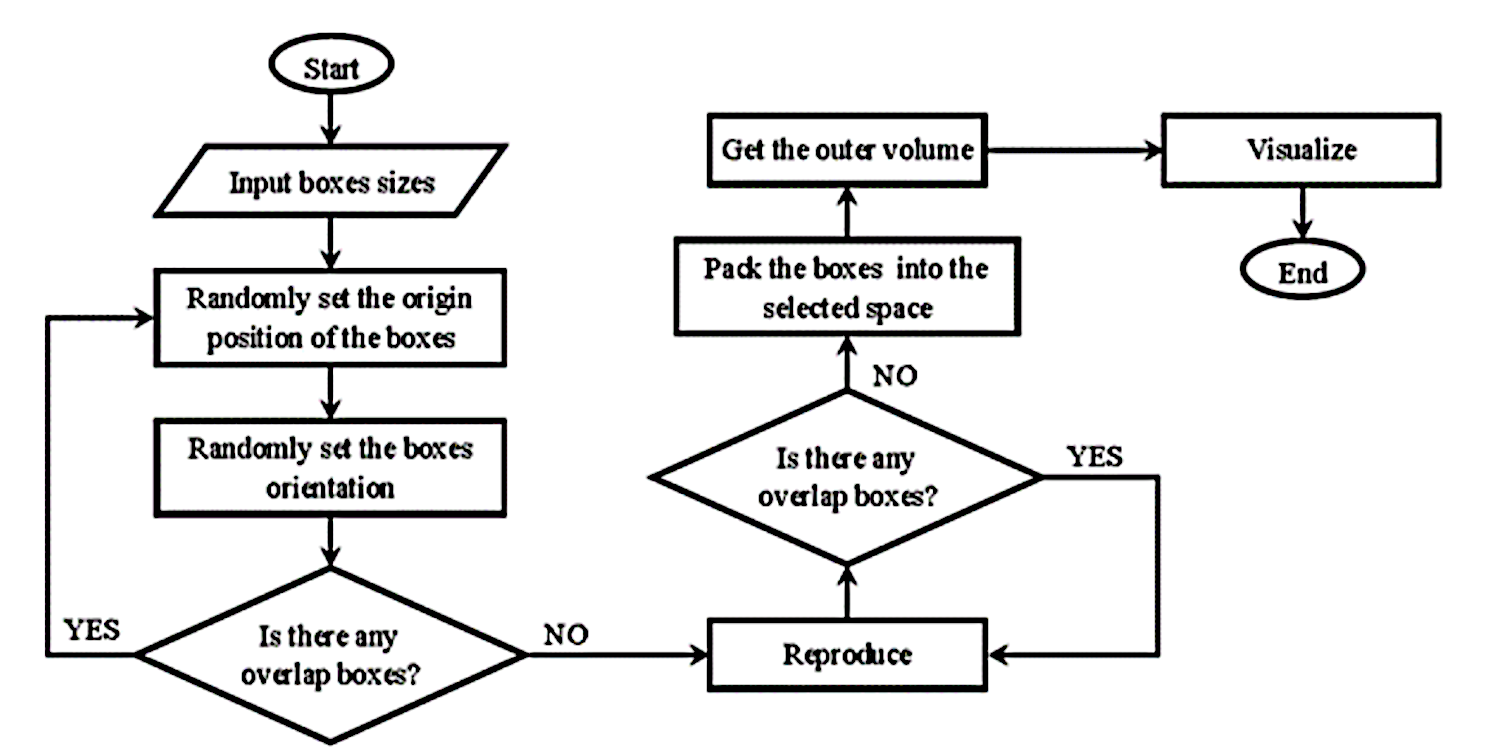

In [10]:
Image(filename = "Algo.png", width=750, height=500)

For random rotations we will assume a Pi/2 rotation. 

We need to sometimes apply a rotation to one of our rectangular prisms. This is a brief overview of the matrix transforms

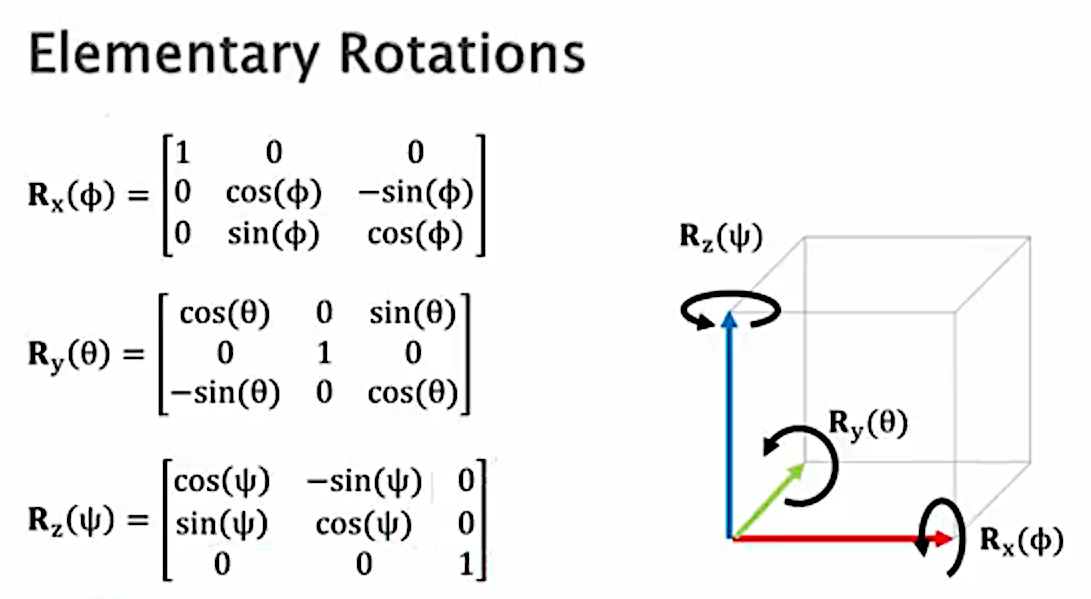

In [11]:
Image(filename = "rotations.png", width=750, height=500)

In [295]:
class GeneticPacking:
    """
    A genetic packing algorithm to find approximate solutions to the 3D bin 
    packing problem
    """

    def __init__(self,
                 num_generations: int = 1000,
                 pop_size: int = 1000,
                 starting_size: int = 1000,
                 size_calc: float = 0,
                 mutation: float = .10,
                 survival: int = 75,
                 keepers: int = 5,
                 csv_location: float = "") -> None:
        """
        Genetic Packing and CSV loader
        ------------------
        :param num_generations:    integer, number of generations to spawn
        :param pop_size:           integer, size of each pop_size
        :param starting_size:      integer, size of starting container
        :param size_calc:          float,   unless 0, takes starting box volumes
                                            and multiples for starting container size
        :param mutation:           float,   % mutation rate for individual
        :param survival:           integer, number of surviving population
        :param keepers:            integer, number of population that survive
                                            after mating
        :param csv_location:       string,  location of packing list .csv
                                            defaults to local folder
        """

        # Basic loading parameters
        self.num_generations = num_generations
        self.pop_size = pop_size
        self.survival = survival
        self.keepers = keepers
        self.mutation = mutation
        
        # Variables to hold
        self.fitness_values = {}
        self.s_values = []
        self.survivors = {}
        self.next_gen = {}
        
        # CSV loading options. Defaults to local folder
        if csv_location == "":
            self.purchase = pd.read_csv("purchase_order.csv", index_col=0)
        else:
            self.purchase = pd.read_csv(csv_location, index_col=0)

        # This syntax is not ideal, here we replace the starting_size value
        # by the size_calc factor
        if size_calc != 0:
            self.starting_size = size_calc * (sum(self.purchase["volume"])) ** (1 / 3)
        else:
            self.starting_size = starting_size

        # To maintain the integrity of each chromosome, we will use a dictionary
        # structure. This is the initial population generator
        self.population = {x: self.individual_generator() for x in range(self.pop_size)}

    def gene_generator(self, index) -> dict:
        """
        A random gene generator for an item in CSV
        ------------------
        :param index:              integer, number of gene to grab from.

        """

        entry = dict(self.purchase.loc[index])

        # Similar to Khairuddin, et al. we will be using 5 of our columns
        # for each chromosome, data usage 5 x n, n number of boxes.
        gene = {"index": index,
                "name": entry["name"],
                "weight": entry["weight"],
                "coordinates": uniform(0, self.starting_size, 3),
                "prism_vector": np.array([entry["length"],
                                          entry["width"],
                                          entry["height"]])}

        return self.random_rotation(gene)

    def individual_generator(self) -> dict:
        """
        A quick random individual random generator
        """
        return {x: self.gene_generator(x) for x in self.purchase.index}

    @staticmethod
    def random_rotation(gene) -> dict:
        """
        Applies a random orientation to a gene prism
        ------------------
        :param gene:               dict, gene information with orientation values
        """
        # Roll is x-axis, pitch is y-axis and yaw is z-axis orientation
        # since I am assuming rectangular prisms, we only consider 4 options
        i = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])           # identity
        r = np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]])          # roll
        p = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]])          # pitch
        y = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])          # yaw

        ###
        # TODO: Consider adding rotations other than Pi/2 ???
        ###

        # Apply random transform to prism vector
        orientations = [i, r, p, y, r * p, r * y, p * y, r * p * y]
        orientation = orientations[choice(len(orientations))]
        gene["prism_vector"] = np.diag(orientation * gene["prism_vector"])

        # This is data needed for our modified overlap calculator
        # rtree coordinates x_min, y_min, z_min, x_max, y_max, z_max
        min_max = [sorted([gene["coordinates"][i],
                           gene["coordinates"][i] + gene["prism_vector"][i]])
                   for i in range(3)]

        gene["rtree_coordinate"] = [min_max[j][i] for i in range(2)
                                    for j in range(len(min_max))]

        return gene

    def fitness_calculator(self, individual) -> float:
        """
        Spacial searching format, Khairuddin, et al. are unclear on how they
        quickly tested if rectangles overlapped. Building a R-tree seems the
        most pythonic option. Returns fitness values as a float.
        ------------------
        :param individual:         integer, the number value for the dict index
        """

        # First initialize the rtree indexer
        p = rtree.index.Property()
        indi = self.population[individual]

        # Next we initialize the properties
        p.dimension = 3
        p.dat_extension = 'data'
        p.idx_extension = 'index'
        idx3d = rtree.index.Index(properties=p)

        # Iterate through all of the genes inside the individual
        i = 0
        while i < len(indi):
            gene_data = self.population[individual][i]

            # If the box intersects another in the set, return infinity fitness
            # since we are minimizing the fitness value, this will effectively kill
            # the individual.
            if len(list(idx3d.intersection(gene_data["rtree_coordinate"]))) > 1:
                return np.Infinity

            idx3d.insert(i, gene_data["rtree_coordinate"])
            i += 1

        # The idx3d bounds returns the format x_min, y_min, ..., y_max, z_max
        bounding_box = idx3d.bounds

        # This list comprehension finds lengths and then multiplies the resulting values
        f_value = np.prod([(bounding_box[i + 3] - bounding_box[i])
                           for i in range(3)])

        # This calculates the surviving individuals from list

        return f_value

    def select(self) -> None:
        """
        Selects top survivors from initial population and populates into dictionary
        """

        # Calculate the fitness of each individual in the population
        self.fitness_values = {}
        for individual in self.population:
            self.fitness_values[individual] = self.fitness_calculator(individual)

        # This can be improved, but for now, we will just sort the dictionary to find survivors
        self.s_values = sorted(self.fitness_values.values())[:self.survival]

        self.survivors = {k: v for k, v in self.fitness_values.items()
                          if v in self.s_values and v != np.Infinity}

        # Sort the survivor dictionary to speed favor best survivors in mating
        self.survivors = dict(sorted(self.survivors.items(),
                                     key=lambda item: item[1]))

    def mutate(self, individual) -> dict:
        """
        Takes population dictionary and randomly reorients boxes with possible
        relocation of object
        """
        
        ###
        # TODO: Khairuddin, et al were unclear on how often to mutate, might be
        #       fun to experiment with different mutation options
        ###
        
        # If mutation occurs, first total reset box location
        for gene in individual:
            if uniform(1) < self.mutation:
                individual[gene]["coordinates"] = uniform(0, self.starting_size, 3)
                individual[gene] = self.random_rotation(individual[gene])
            else:
                individual[gene] = self.random_rotation(individual[gene])
                
        return individual        
        
    def mate(self) -> None:
        """
        This function takes members of the surviving population and
        mates them by choosing a partition value, makes a new dictionary with
        the values, and then creates the next generation.
        """

        self.next_gen = {}
        
        # First, pass the keepers into the next generation
        survive_keys = list(self.survivors.keys())[:self.keepers]        
        old_num = {k: v for k, v in self.population.items() if k in survive_keys}
        
        # Renumber keys
        for i, values in enumerate(old_num.items()):
            self.next_gen[i] = values[1]

        # We will be keeping the index values for renumbering 
        current_key = self.keepers
        
        # Next we select one of the top % to mate with the general population
        mating_keys = list(self.survivors.keys())[:int(self.pop_size * self.mutation)]
        gen_keys = set(self.survivors.keys())
        
        # This may go 1 over pop_size, but that is not a problem
        while current_key < self.pop_size:
            # Choose our lucky couple, partition and mate
            boy_num = choice(mating_keys)
            boy = self.population[boy_num]

            # Numpy can't choose from a set, so making a list from set first
            girl_num = choice(list(set(mating_keys) - {boy_num}))
            girl = self.population[girl_num]

            # This is the splice partition
            splice = int(len(boy))
            self.next_gen[current_key] = child = {k: v for k,v in boy.items() if k < splice}
            child.update({k: v for k,v in girl.items() if k >= splice})
            child = self.mutate(child) #self.next_gen[current_key]
            current_key += 1

            # Now we splice from the other direction
            self.next_gen[current_key] = child = {k: v for k,v in boy.items() if k >= splice}
            child.update({k: v for k,v in girl.items() if k < splice})
            self.next_gen[current_key] = self.mutate(child)
            current_key += 1




In [296]:
df = GeneticPacking(size_calc = 1.75)

In [297]:
df.select()

In [298]:
df.mate()

In [300]:
len(df.next_gen)

1001

In [234]:
df.next_gen[5]

{0: {'index': 0,
  'name': 'DmtifMZKqtea',
  'weight': 1418,
  'coordinates': array([20.60923674, 95.5002531 , 96.35329636]),
  'prism_vector': array([-45, -39,  57]),
  'rtree_coordinate': [-24.390763263549154,
   56.50025309734153,
   96.35329635702122,
   20.609236736450846,
   95.50025309734153,
   153.35329635702124]},
 1: {'index': 1,
  'name': 'UbsBgwprWIkB',
  'weight': 639,
  'coordinates': array([75.95402377, 85.65278328, 30.12170445]),
  'prism_vector': array([-15, -32, -39]),
  'rtree_coordinate': [60.95402376680448,
   53.65278328192457,
   -8.878295549563529,
   75.95402376680448,
   85.65278328192457,
   30.12170445043647]},
 2: {'index': 2,
  'name': 'kirorzOhhjSs',
  'weight': 236,
  'coordinates': array([103.77681385,  13.47574304,  54.38179541]),
  'prism_vector': array([ 56, -32,  16]),
  'rtree_coordinate': [103.77681385442301,
   -18.524256964869355,
   54.38179540633717,
   159.776813854423,
   13.475743035130645,
   70.38179540633718]},
 3: {'index': 3,
  'name'

In [167]:
for i,j in enumerate(df.survivors.items()):
    print(i,j[1])

0 3300263.264360809
1 3697882.0511926
2 3870507.0252441964
3 3893593.448679662
4 3985678.8103858
5 4082108.1713409326
6 4139543.710533794
7 4276834.981239469
8 4326905.256405475
9 4371444.414092006
10 4377997.118871505
11 4379147.627257262
12 4434710.410860272
13 4444191.265706502
14 4597305.76796616
15 4614096.770937145
16 4626634.766494737
17 4628492.751855426
18 4639779.839960425
19 4672352.62214034
20 4677952.937596153
21 4695948.2342355605
22 4709042.26817306
23 4709450.212989636
24 4730882.898634399
25 4741434.515473017
26 4759637.296362075
27 4772337.633618132
28 4789419.938370649
29 4853822.4130438715
30 4863483.558080348
31 4887449.75058286
32 4920561.144261998
33 4942492.130579859
34 4961953.62113977
35 4971104.765562531
36 4978877.648188718
37 5069454.676429505
38 5115575.243564511
39 5139553.438961708
40 5159143.5278275125
41 5211355.589648021
42 5289638.712100891
43 5306240.47700164
44 5309960.240293668
45 5312227.051839948
46 5317348.491473253
47 5321653.653586249
48 5359

In [145]:
df.population[0]

{0: {'index': 0,
  'name': 'DmtifMZKqtea',
  'weight': 1418,
  'coordinates': array([ 74.36451277,  41.04398607, 109.3916503 ]),
  'prism_vector': array([-45, -39,  57]),
  'rtree_coordinate': [29.364512772802,
   2.043986073776715,
   109.39165030412317,
   74.364512772802,
   41.043986073776715,
   166.39165030412317]},
 1: {'index': 1,
  'name': 'UbsBgwprWIkB',
  'weight': 639,
  'coordinates': array([ 5.88199247,  0.18917648, 68.33394961]),
  'prism_vector': array([-15, -32,  39]),
  'rtree_coordinate': [-9.118007534394119,
   -31.8108235191981,
   68.33394960748309,
   5.881992465605881,
   0.18917648080190094,
   107.33394960748309]},
 2: {'index': 2,
  'name': 'kirorzOhhjSs',
  'weight': 236,
  'coordinates': array([49.03122998, 39.47457853, 48.3901664 ]),
  'prism_vector': array([-56,  32, -16]),
  'rtree_coordinate': [-6.968770016878246,
   39.47457852938224,
   32.390166400455215,
   49.031229983121754,
   71.47457852938224,
   48.390166400455215]},
 3: {'index': 3,
  'name':

In [232]:
a = [[678.987835712282, 716.987835712282],
   [720.0331604416158, 754.0331604416158],
   [689.0804572845304, 745.0804572845304]]

In [235]:
a[2]

[689.0804572845304, 745.0804572845304]

In [240]:
[]

TypeError: 'list' object cannot be interpreted as an integer

In [248]:
b = [a[j][i] for i in range(2) for j in range(len(a))]

In [249]:
b

[678.987835712282,
 720.0331604416158,
 689.0804572845304,
 716.987835712282,
 754.0331604416158,
 745.0804572845304]

## Citations

[1] Khairuddin, U., Razi, N. A., Abidin, M. S., &amp; Yusof, R. (2020). Smart packing simulator for 3D packing problem using genetic algorithm. Journal of Physics: Conference Series, 1447, 012041. doi:10.1088/1742-6596/1447/1/012041